# Student Category Distribution

In [2]:
# Re-import libraries after code execution state reset
import pandas as pd
import networkx as nx
import os

# Re-extract the ZIP file contents since previous state was reset
import zipfile

extract_path = "/Users/aaronsalazar/LocalDocs/Bologna/SocialNetwork/dataset"

# Re-identify edge and node files
all_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        all_files.append(os.path.join(root, file))

edge_files = [f for f in all_files if "Edges" in f]
node_files = [f for f in all_files if "Nodes" in f]

# Prepare a summary for neuron category distribution
neuron_category_summary = {}

for edge_file in edge_files:
    school_id = edge_file.split("/")[-1].replace("Edges_", "").replace(".csv", "")
    
    try:
        edge_df = pd.read_csv(edge_file)
        node_file = edge_file.replace("Edges", "Nodes")
        if not os.path.exists(node_file):
            continue
        node_df = pd.read_csv(node_file)

        # Detect ID column
        id_col = None
        for col in node_df.columns:
            if col.lower() == "id":
                id_col = col
                break
        if not id_col and "ID" in node_df.columns:
            id_col = "ID"
        if not id_col:
            continue

        if not {'from', 'to', 'weight'}.issubset(edge_df.columns):
            continue

        # Filter for positive edges
        positive_edges = edge_df[edge_df['weight'] > 0]

        # Build graph
        G = nx.DiGraph()
        G.add_nodes_from(node_df[id_col])
        G.add_weighted_edges_from(positive_edges[['from', 'to', 'weight']].values)

        # Compute degree centrality
        deg = nx.degree_centrality(G)

        # Sort by centrality
        sorted_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)
        total = len(sorted_deg)

        high_cutoff = int(0.10 * total)
        moderate_cutoff = int(0.50 * total)

        categories = {"high_degree": 0, "moderate_degree": 0, "low_degree": 0, "isolated": 0}

        for i, (node, centrality) in enumerate(sorted_deg):
            if centrality == 0:
                categories["isolated"] += 1
            elif i < high_cutoff:
                categories["high_degree"] += 1
            elif i < moderate_cutoff:
                categories["moderate_degree"] += 1
            else:
                categories["low_degree"] += 1

        neuron_category_summary[school_id] = categories

    except Exception as e:
        neuron_category_summary[school_id] = {
            "error": str(e)
        }

neuron_df = pd.DataFrame.from_dict(neuron_category_summary, orient='index')
neuron_df.head()

,high_degree,moderate_degree,low_degree,isolated
t11_8,37,151,187,1
t11_9,50,204,255,0
t6,53,214,267,0
t11_7,10,42,52,0
t11_6,14,58,73,0


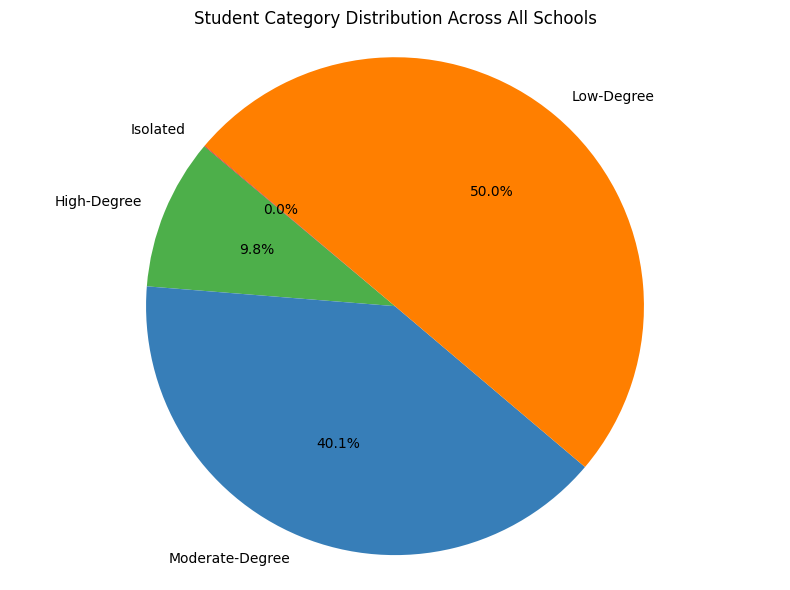

In [4]:
import matplotlib.pyplot as plt

# Sum category totals across all schools
total_counts = {
    "High-Degree": 0,
    "Moderate-Degree": 0,
    "Low-Degree": 0,
    "Isolated": 0
}

for row in neuron_category_summary.values():
    if "error" in row:
        continue
    total_counts["High-Degree"] += row["high_degree"]
    total_counts["Moderate-Degree"] += row["moderate_degree"]
    total_counts["Low-Degree"] += row["low_degree"]
    total_counts["Isolated"] += row["isolated"]

# Create pie chart
labels = list(total_counts.keys())
sizes = list(total_counts.values())
colors = ['#4daf4a', '#377eb8', '#ff7f00', '#e41a1c']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Student Category Distribution Across All Schools")
plt.axis('equal')
plt.tight_layout()
plt.show()


# Scalar Network Analysis

In [6]:
# Prepare a summary dictionary for scalar network analysis
scalar_summary = {}

# Compute density, number of nodes, number of edges, and average degree
for edge_file in edge_files:
    school_id = edge_file.split("/")[-1].replace("Edges_", "").replace(".csv", "")
    
    try:
        edge_df = pd.read_csv(edge_file)
        node_file = edge_file.replace("Edges", "Nodes")
        if not os.path.exists(node_file):
            continue
        node_df = pd.read_csv(node_file)

        # Detect ID column
        id_col = None
        for col in node_df.columns:
            if col.lower() == "id":
                id_col = col
                break
        if not id_col and "ID" in node_df.columns:
            id_col = "ID"
        if not id_col:
            continue

        if not {'from', 'to', 'weight'}.issubset(edge_df.columns):
            continue

        # Filter for positive edges
        positive_edges = edge_df[edge_df['weight'] > 0]

        # Build directed graph
        G = nx.DiGraph()
        G.add_nodes_from(node_df[id_col])
        G.add_weighted_edges_from(positive_edges[['from', 'to', 'weight']].values)

        # Calculate scalar metrics
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_degree = num_edges / num_nodes if num_nodes > 0 else 0
        assortativity = nx.degree_pearson_correlation_coefficient(G) if num_edges > 1 else None

        scalar_summary[school_id] = {
            "num_nodes": num_nodes,
            "num_edges": num_edges,
            "density": density,
            "average_degree": avg_degree,
            "assortativity": assortativity
        }

    except Exception as e:
        scalar_summary[school_id] = {
            "error": str(e)
        }

scalar_df = pd.DataFrame.from_dict(scalar_summary, orient='index')
scalar_df.head()

,num_nodes,num_edges,density,average_degree,assortativity
t11_8,376,2541,0.018021,6.757979,0.041366
t11_9,509,4618,0.017860,9.072692,-0.016376
t6,534,11024,0.038732,20.644195,-0.019098
t11_7,104,980,0.091486,9.423077,-0.063199
t11_6,145,1860,0.089080,12.827586,0.097023


# Small-World Network Analysis

In [7]:
# Prepare a summary dictionary for small-world analysis
small_world_summary = {}

# Calculate clustering coefficient and average path length for each network and compare with random graph
for edge_file in edge_files:
    school_id = edge_file.split("/")[-1].replace("Edges_", "").replace(".csv", "")
    
    try:
        edge_df = pd.read_csv(edge_file)
        node_file = edge_file.replace("Edges", "Nodes")
        if not os.path.exists(node_file):
            continue
        node_df = pd.read_csv(node_file)

        # Detect ID column
        id_col = None
        for col in node_df.columns:
            if col.lower() == "id":
                id_col = col
                break
        if not id_col and "ID" in node_df.columns:
            id_col = "ID"
        if not id_col:
            continue

        if not {'from', 'to', 'weight'}.issubset(edge_df.columns):
            continue

        # Filter for positive edges
        positive_edges = edge_df[edge_df['weight'] > 0]

        # Build directed graph
        G = nx.DiGraph()
        G.add_nodes_from(node_df[id_col])
        G.add_weighted_edges_from(positive_edges[['from', 'to', 'weight']].values)

        # Use largest strongly connected component for meaningful comparison
        if not nx.is_strongly_connected(G):
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            H = G.subgraph(largest_scc).copy()
        else:
            H = G

        # Convert to undirected graph for clustering and path length
        H_undirected = H.to_undirected()

        # Calculate real clustering and path length
        clustering_real = nx.average_clustering(H_undirected)
        path_length_real = nx.average_shortest_path_length(H)

        # Create a random graph with same number of nodes and edges
        num_nodes = H.number_of_nodes()
        num_edges = H.number_of_edges()
        G_random = nx.gnm_random_graph(num_nodes, num_edges)

        clustering_rand = nx.average_clustering(G_random)
        path_length_rand = nx.average_shortest_path_length(G_random)

        # Compute small-world coefficient sigma
        sigma = (clustering_real / clustering_rand) / (path_length_real / path_length_rand)

        small_world_summary[school_id] = {
            "clustering_real": clustering_real,
            "path_length_real": path_length_real,
            "clustering_rand": clustering_rand,
            "path_length_rand": path_length_rand,
            "sigma": sigma
        }

    except Exception as e:
        small_world_summary[school_id] = {
            "error": str(e)
        }

sw_df = pd.DataFrame.from_dict(small_world_summary, orient='index')
sw_df.head()

,clustering_real,path_length_real,clustering_rand,path_length_rand,sigma
t11_8,0.497399,2.643113,0.247409,1.755248,1.335094
t11_9,0.488138,2.511103,0.233299,1.773726,1.477924
t6,0.492642,3.455217,0.086285,1.936049,3.199157
t11_7,0.539766,2.585789,0.264328,1.738246,1.372714
t11_6,0.427430,2.352502,0.256125,1.750560,1.241822


# Modularity

In [8]:
# Prepare a summary dictionary for modularity
from networkx.algorithms.community import greedy_modularity_communities

modularity_summary = {}

# Calculate modularity using undirected positive-edge graphs
for edge_file in edge_files:
    school_id = edge_file.split("/")[-1].replace("Edges_", "").replace(".csv", "")

    try:
        edge_df = pd.read_csv(edge_file)
        node_file = edge_file.replace("Edges", "Nodes")
        if not os.path.exists(node_file):
            continue
        node_df = pd.read_csv(node_file)

        # Detect ID column
        id_col = None
        for col in node_df.columns:
            if col.lower() == "id":
                id_col = col
                break
        if not id_col and "ID" in node_df.columns:
            id_col = "ID"
        if not id_col:
            continue

        if not {'from', 'to', 'weight'}.issubset(edge_df.columns):
            continue

        # Filter for positive edges
        positive_edges = edge_df[edge_df['weight'] > 0]

        # Build undirected graph for modularity
        G = nx.Graph()
        G.add_nodes_from(node_df[id_col])
        G.add_edges_from(positive_edges[['from', 'to']].values)

        # Detect communities
        communities = list(greedy_modularity_communities(G))
        community_map = {node: i for i, com in enumerate(communities) for node in com}

        # Compute modularity
        mod = nx.algorithms.community.quality.modularity(G, communities)

        modularity_summary[school_id] = {
            "modularity": mod,
            "num_communities": len(communities)
        }

    except Exception as e:
        modularity_summary[school_id] = {
            "error": str(e)
        }

modularity_df = pd.DataFrame.from_dict(modularity_summary, orient='index')
modularity_df.head()

,modularity,num_communities
t11_8,0.724155,5
t11_9,0.724620,5
t6,0.706273,4
t11_7,0.403084,3
t11_6,0.247732,3


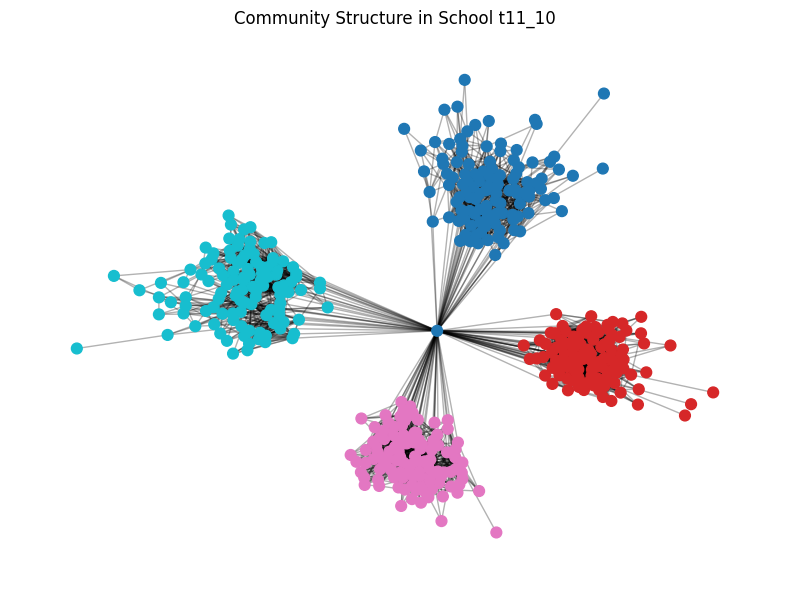

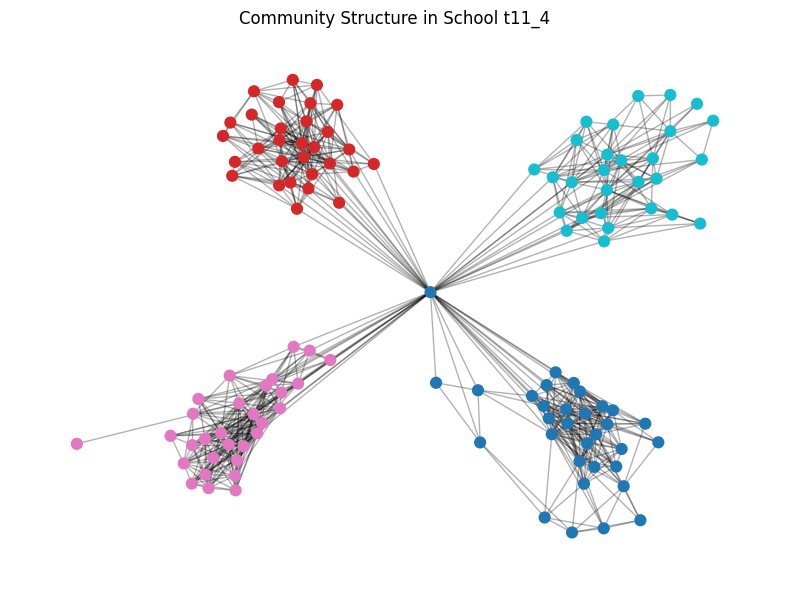

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize communities in a network
def plot_communities(school_id, edge_file, node_file):
    edge_df = pd.read_csv(edge_file)
    node_df = pd.read_csv(node_file)

    # Detect ID column
    id_col = None
    for col in node_df.columns:
        if col.lower() == "id":
            id_col = col
            break
    if not id_col and "ID" in node_df.columns:
        id_col = "ID"
    if not id_col:
        return

    # Filter for positive edges
    positive_edges = edge_df[edge_df['weight'] > 0]

    # Build undirected graph
    G = nx.Graph()
    G.add_nodes_from(node_df[id_col])
    G.add_edges_from(positive_edges[['from', 'to']].values)

    # Detect communities
    communities = list(greedy_modularity_communities(G))
    community_map = {}
    for i, com in enumerate(communities):
        for node in com:
            community_map[node] = i

    # Assign colors by community
    node_colors = [community_map.get(node, -1) for node in G.nodes()]

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=60)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Community Structure in School {school_id}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot for t11_10 and t11_4
plot_communities("t11_10", "/Users/aaronsalazar/LocalDocs/Bologna/SocialNetwork/dataset/Edges_t11_10.csv", "/Users/aaronsalazar/LocalDocs/Bologna/SocialNetwork/dataset/Nodes_t11_10.csv")
plot_communities("t11_4", "/Users/aaronsalazar/LocalDocs/Bologna/SocialNetwork/dataset/Edges_t11_4.csv", "/Users/aaronsalazar/LocalDocs/Bologna/SocialNetwork/dataset/Nodes_t11_4.csv")

# Scale Freeness

In [ ]:
import numpy as np
import scipy.stats as stats

# Prepare a summary dictionary for scale freeness
scale_free_summary = {}

# Analyze degree distributions
for edge_file in edge_files:
    school_id = edge_file.split("/")[-1].replace("Edges_", "").replace(".csv", "")

    try:
        edge_df = pd.read_csv(edge_file)
        node_file = edge_file.replace("Edges", "Nodes")
        if not os.path.exists(node_file):
            continue
        node_df = pd.read_csv(node_file)

        # Detect ID column
        id_col = None
        for col in node_df.columns:
            if col.lower() == "id":
                id_col = col
                break
        if not id_col and "ID" in node_df.columns:
            id_col = "ID"
        if not id_col:
            continue

        if not {'from', 'to', 'weight'}.issubset(edge_df.columns):
            continue

        # Filter positive edges
        positive_edges = edge_df[edge_df['weight'] > 0]

        # Build undirected graph for degree analysis
        G = nx.Graph()
        G.add_nodes_from(node_df[id_col])
        G.add_edges_from(positive_edges[['from', 'to']].values)

        # Compute degree sequence
        degrees = [deg for _, deg in G.degree() if deg > 0]
        if len(degrees) < 2:
            continue

        # Fit power-law to degree distribution using linear regression in log-log scale
        log_degrees = np.log10(degrees)
        log_counts = np.log10(np.bincount(degrees)[1:])  # exclude degree 0

        valid = ~np.isnan(log_counts) & ~np.isinf(log_counts)
        x = np.arange(1, len(log_counts) + 1)[valid]
        y = log_counts[valid]

        if len(x) > 1:
            slope, intercept, r_value, _, _ = stats.linregress(np.log10(x), y)
        else:
            slope, r_value = np.nan, 0

        scale_free_summary[school_id] = {
            "slope": slope,
            "r_squared": r_value ** 2
        }

    except Exception as e:
        scale_free_summary[school_id] = {
            "error": str(e)
        }

sf_df = pd.DataFrame.from_dict(scale_free_summary, orient='index')
sf_df.head()

/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_29871/1131071996.py:47: RuntimeWarning: divide by zero encountered in log10
  log_counts = np.log10(np.bincount(degrees)[1:])  # exclude degree 0
/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_29871/1131071996.py:47: RuntimeWarning: divide by zero encountered in log10
  log_counts = np.log10(np.bincount(degrees)[1:])  # exclude degree 0
/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_29871/1131071996.py:47: RuntimeWarning: divide by zero encountered in log10
  log_counts = np.log10(np.bincount(degrees)[1:])  # exclude degree 0
/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_29871/1131071996.py:47: RuntimeWarning: divide by zero encountered in log10
  log_counts = np.log10(np.bincount(degrees)[1:])  # exclude degree 0
/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_29871/1131071996.py:47: RuntimeWarning: divide by zero encountered in log10
  log_counts = np.log10(np.bincount(degrees)[

,slope,r_squared
t11_8,-1.099534,0.670954
t11_9,-0.964088,0.605517
t6,-0.229152,0.024475
t11_7,-0.322097,0.129484
t11_6,-0.199295,0.057375
